In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, AutoConfig
from datasets import load_dataset, concatenate_datasets
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import os
from typing import Dict, List, Tuple, Optional
import random

import warnings
warnings.filterwarnings('ignore')


/home/jivnesh/anaconda3/envs/RishiSurge/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU count: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")


Using device: cuda
GPU count: 4
GPU 0: NVIDIA TITAN RTX
GPU 1: NVIDIA TITAN RTX
GPU 2: NVIDIA TITAN RTX
GPU 3: NVIDIA TITAN RTX


In [4]:
def load_and_sample_raid_data(target,samples_per_class=75000, seed=42):
    """Loads RAID from HF, creates a balanced sample of human and gpt-4 texts."""
    print("Loading 'liamdugan/raid' dataset from Hugging Face Hub...")
    dataset = load_dataset("liamdugan/raid", split="train") 
    
    # Filter by model type
    human_ds = dataset.filter(lambda x: x['model'] == 'human').shuffle(seed=seed)
    gpt4_ds = dataset.filter(lambda x: x['model'] == target).shuffle(seed=seed)
    
    num_human = min(samples_per_class, len(human_ds))
    num_gpt4 = min(samples_per_class, len(gpt4_ds))
    
    print(f"Available samples - Human: {len(human_ds)}, GPT-4: {len(gpt4_ds)}")
    print(f"Selecting {num_human} human samples and {num_gpt4} gpt-4 samples...")
    
    human_samples = human_ds.select(range(num_human))
    gpt4_samples = gpt4_ds.select(range(num_gpt4))

    # Combine and shuffle
    combined_ds = concatenate_datasets([human_samples, gpt4_samples])
    return combined_ds.shuffle(seed=seed)

In [ ]:
print("Loading RAID dataset...")
dataset = load_and_sample_raid_data(samples_per_class=20000)  # 150k total samples
print(f"Total samples loaded: {len(dataset)}")


In [5]:
print("\nDataset structure:")
print(dataset.features)
print(f"\nSample columns: {dataset.column_names}")
print(f"\nFirst example keys: {dataset[0].keys()}")



Dataset structure:


NameError: name 'dataset' is not defined

In [4]:
class ContrastiveDataset(Dataset):
    def __init__(self, texts, labels, topics, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels  # 0 for human, 1 for gpt4
        self.topics = topics
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        # Group by topic and label for efficient sampling
        self.topic_groups = {}
        for idx, (topic, label) in enumerate(zip(topics, labels)):
            if topic not in self.topic_groups:
                self.topic_groups[topic] = {'human': [], 'gpt4': []}
            
            label_name = 'human' if label == 0 else 'gpt4'
            self.topic_groups[topic][label_name].append(idx)
    
    def __len__(self):
        return len(self.texts)
    
    def create_contrastive_triplet(self, anchor_idx):
        """Create anchor, positive, negative triplet"""
        anchor_topic = self.topics[anchor_idx]
        anchor_label = self.labels[anchor_idx]
        anchor_label_name = 'human' if anchor_label == 0 else 'gpt4'
        opposite_label_name = 'gpt4' if anchor_label == 0 else 'human'
        
        # Strategy selection (as discussed earlier)
        strategy = np.random.choice([
            'content_matched',    # 40% - Same topic, different styles
            'topic_matched',      # 30% - Same topic, same style
            'cross_topic',        # 20% - Different topics, same style
            'hard_negative'       # 10% - Different topics, different styles
        ], p=[0.4, 0.3, 0.2, 0.1])
        
        if strategy == 'content_matched' and len(self.topic_groups[anchor_topic][opposite_label_name]) > 0:
            # Same topic, different style (best for style learning)
            positive_idx = np.random.choice(self.topic_groups[anchor_topic][anchor_label_name])
            while positive_idx == anchor_idx:
                positive_idx = np.random.choice(self.topic_groups[anchor_topic][anchor_label_name])
            negative_idx = np.random.choice(self.topic_groups[anchor_topic][opposite_label_name])
            
        elif strategy == 'topic_matched':
            # Same topic, random pairing
            positive_idx = np.random.choice(self.topic_groups[anchor_topic][anchor_label_name])
            while positive_idx == anchor_idx:
                positive_idx = np.random.choice(self.topic_groups[anchor_topic][anchor_label_name])
            negative_idx = np.random.choice(self.topic_groups[anchor_topic][opposite_label_name]) if len(self.topic_groups[anchor_topic][opposite_label_name]) > 0 else np.random.choice([i for i, l in enumerate(self.labels) if l != anchor_label])
            
        elif strategy == 'cross_topic':
            # Different topics, same style
            other_topics = [t for t in self.topic_groups.keys() if t != anchor_topic]
            if other_topics:
                pos_topic = np.random.choice(other_topics)
                positive_idx = np.random.choice(self.topic_groups[pos_topic][anchor_label_name]) if len(self.topic_groups[pos_topic][anchor_label_name]) > 0 else np.random.choice([i for i, l in enumerate(self.labels) if l == anchor_label])
            else:
                positive_idx = np.random.choice([i for i, l in enumerate(self.labels) if l == anchor_label and i != anchor_idx])
            negative_idx = np.random.choice([i for i, l in enumerate(self.labels) if l != anchor_label])
            
        else:  # hard_negative
            # Random pairing
            positive_idx = np.random.choice([i for i, l in enumerate(self.labels) if l == anchor_label and i != anchor_idx])
            negative_idx = np.random.choice([i for i, l in enumerate(self.labels) if l != anchor_label])
        
        return {
            'anchor': self.texts[anchor_idx],
            'positive': self.texts[positive_idx],
            'negative': self.texts[negative_idx],
            'anchor_label': anchor_label
        }
    
    def __getitem__(self, idx):
        triplet = self.create_contrastive_triplet(idx)
        
        # Tokenize all three texts
        anchor_tokens = self.tokenizer(
            triplet['anchor'], 
            max_length=self.max_length, 
            truncation=True, 
            padding='max_length', 
            return_tensors='pt'
        )
        
        positive_tokens = self.tokenizer(
            triplet['positive'], 
            max_length=self.max_length, 
            truncation=True, 
            padding='max_length', 
            return_tensors='pt'
        )
        
        negative_tokens = self.tokenizer(
            triplet['negative'], 
            max_length=self.max_length, 
            truncation=True, 
            padding='max_length', 
            return_tensors='pt'
        )
        
        return {
            'anchor_input_ids': anchor_tokens['input_ids'].squeeze(),
            'anchor_attention_mask': anchor_tokens['attention_mask'].squeeze(),
            'positive_input_ids': positive_tokens['input_ids'].squeeze(),
            'positive_attention_mask': positive_tokens['attention_mask'].squeeze(),
            'negative_input_ids': negative_tokens['input_ids'].squeeze(),
            'negative_attention_mask': negative_tokens['attention_mask'].squeeze(),
            'anchor_label': triplet['anchor_label']
        }


In [ ]:
def prepare_contrastive_data(dataset):
    """Convert RAID dataset to contrastive learning format"""
    texts = []
    labels = []
    topics = []
    
    for example in dataset:
        texts.append(example['generation'])
        labels.append(0 if example['model'] == 'human' else 1)
        topics.append(example.get('domain', 'general'))  # Use domain as topic
    
    return texts, labels, topics


In [ ]:

print("Preparing contrastive learning data...")
texts, labels, topics = prepare_contrastive_data(dataset)


In [ ]:
print(f"Data summary:")
print(f"Total texts: {len(texts)}")
print(f"Human samples: {sum(1 for l in labels if l == 0)}")
print(f"GPT-4 samples: {sum(1 for l in labels if l == 1)}")
print(f"Unique topics: {len(set(topics))}")
print(f"Topics: {set(topics)}")

In [5]:
class StyleContrastiveEncoder(nn.Module):
    def __init__(self, 
                 base_model="microsoft/deberta-v3-base",
                 embedding_dim=256,
                 dropout=0.1,
                 freeze_backbone=False):
        super().__init__()
        
        # Load pretrained backbone
        self.backbone = AutoModel.from_pretrained(base_model)
        self.tokenizer = AutoTokenizer.from_pretrained(base_model)
        
        # Optionally freeze backbone for faster training
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        # Projection head for contrastive learning
        backbone_dim = self.backbone.config.hidden_size
        self.projection_head = nn.Sequential(
            nn.Linear(backbone_dim, backbone_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(backbone_dim // 2, embedding_dim),
            nn.LayerNorm(embedding_dim)
        )
        
        print(f"Model initialized with {backbone_dim} -> {embedding_dim} projection")
        
    def forward(self, input_ids, attention_mask):
        # Get contextual embeddings from backbone
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        
        # Attention-weighted pooling
        hidden_states = outputs.last_hidden_state
        attention_weights = attention_mask.unsqueeze(-1).float()
        pooled = (hidden_states * attention_weights).sum(1) / attention_weights.sum(1)
        
        # Project to contrastive space
        style_embedding = self.projection_head(pooled)
        
        # L2 normalize for cosine similarity
        style_embedding = F.normalize(style_embedding, p=2, dim=1)
        
        return style_embedding

In [6]:
class InfoNCELoss(nn.Module):
    def __init__(self, temperature=0.1):
        super().__init__()
        self.temperature = temperature
        
    def forward(self, anchor, positive, negative):
        """
        anchor: [batch_size, embedding_dim]
        positive: [batch_size, embedding_dim] 
        negative: [batch_size, embedding_dim]
        """
        batch_size = anchor.size(0)
        
        # Compute similarities
        pos_sim = torch.sum(anchor * positive, dim=1) / self.temperature  # [batch_size]
        neg_sim = torch.sum(anchor * negative, dim=1) / self.temperature  # [batch_size]
        
        # InfoNCE loss - positive should be more similar than negative
        logits = torch.stack([pos_sim, neg_sim], dim=1)  # [batch_size, 2]
        labels = torch.zeros(batch_size, dtype=torch.long, device=anchor.device)  # Positive is index 0
        
        loss = F.cross_entropy(logits, labels)
        
        # Additional metrics
        with torch.no_grad():
            accuracy = (pos_sim > neg_sim).float().mean()
            
        return loss, accuracy


In [8]:
def create_data_loaders(texts, labels, topics, tokenizer, batch_size=32, test_size=0.2):
    """Create train/validation data loaders"""
    
    # Split data
    train_texts, val_texts, train_labels, val_labels, train_topics, val_topics = train_test_split(
        texts, labels, topics, test_size=test_size, random_state=42, stratify=labels
    )
    
    print(f"Train samples: {len(train_texts)}")
    print(f"Validation samples: {len(val_texts)}")
    
    # Create datasets
    train_dataset = ContrastiveDataset(train_texts, train_labels, train_topics, tokenizer)
    val_dataset = ContrastiveDataset(val_texts, val_labels, val_topics, tokenizer)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    return train_loader, val_loader, (val_texts, val_labels, val_topics)


In [7]:
print("Initializing model...")
model = StyleContrastiveEncoder(
    base_model="microsoft/deberta-v3-base",
    embedding_dim=256,
    dropout=0.1,
    freeze_backbone=False
)


Initializing model...


Model initialized with 768 -> 256 projection


In [8]:
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

model = model.to(device)


Using 4 GPUs


In [ ]:
# run = wandb.init(
#     # Set the project name, this helps you group runs
#     project="style-detection-contrastive", 
    
#     # Track hyperparameters and run metadata
#     config={
#     "learning_rate": 2e-5,
#     "architecture": "DeBERTa-v3-base",
#     "dataset": "RAID-150k",
#     "epochs": 3,
#     })
print("Creating data loaders...")
train_loader, val_loader, val_data = create_data_loaders(
    texts, labels, topics, model.module.tokenizer if hasattr(model, 'module') else model.tokenizer,
    batch_size=16
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")


In [9]:
class StyleTrainer:
    def __init__(self, model, train_loader, val_loader, device, lr=2e-5):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        
        # Optimizer and scheduler
        self.optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50)
        
        # Loss function
        self.criterion = InfoNCELoss(temperature=0.1)
        
        # Tracking
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_epoch(self):
        self.model.train()
        total_loss = 0
        total_accuracy = 0
        num_batches = 0
        
        pbar = tqdm(self.train_loader, desc="Training")
        for batch in pbar:
            self.optimizer.zero_grad()
            
            # Move batch to device
            batch = {k: v.to(self.device,non_blocking=True) for k, v in batch.items()}
            
            # Forward pass
            anchor_emb = self.model(batch['anchor_input_ids'], batch['anchor_attention_mask'])
            positive_emb = self.model(batch['positive_input_ids'], batch['positive_attention_mask'])
            negative_emb = self.model(batch['negative_input_ids'], batch['negative_attention_mask'])
            
            # Compute loss
            loss, accuracy = self.criterion(anchor_emb, positive_emb, negative_emb)
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            
            # Track metrics
            total_loss += loss.item()
            total_accuracy += accuracy.item()
            num_batches += 1
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{accuracy.item():.4f}'
            })
        
        avg_loss = total_loss / num_batches
        avg_accuracy = total_accuracy / num_batches
        
        self.train_losses.append(avg_loss)
        self.train_accuracies.append(avg_accuracy)
        
        return avg_loss, avg_accuracy
    
    def validate_epoch(self):
        self.model.eval()
        total_loss = 0
        total_accuracy = 0
        num_batches = 0
        
        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc="Validation"):
                # Move batch to device
                batch = {k: v.to(self.device,non_blocking=True) for k, v in batch.items()}
                
                # Forward pass
                anchor_emb = self.model(batch['anchor_input_ids'], batch['anchor_attention_mask'])
                positive_emb = self.model(batch['positive_input_ids'], batch['positive_attention_mask'])
                negative_emb = self.model(batch['negative_input_ids'], batch['negative_attention_mask'])
                
                # Compute loss
                loss, accuracy = self.criterion(anchor_emb, positive_emb, negative_emb)
                
                total_loss += loss.item()
                total_accuracy += accuracy.item()
                num_batches += 1
        
        avg_loss = total_loss / num_batches
        avg_accuracy = total_accuracy / num_batches
        
        self.val_losses.append(avg_loss)
        self.val_accuracies.append(avg_accuracy)
        
        return avg_loss, avg_accuracy
    
    def train(self, num_epochs=10):
        best_val_acc = 0
        
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch + 1}/{num_epochs}")
            
            # Training
            train_loss, train_acc = self.train_epoch()
            
            # Validation
            val_loss, val_acc = self.validate_epoch()
            
            # Learning rate scheduling
            self.scheduler.step()
            
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            print(f"Learning Rate: {self.optimizer.param_groups[0]['lr']:.6f}")
            wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "validation_loss": val_loss,
            "validation_accuracy": val_acc})
            
            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_acc': val_acc,
                }, 'best_style_model.pt')
                print(f"New best model saved with validation accuracy: {val_acc:.4f}")

        
        return best_val_acc


In [ ]:
trainer = StyleTrainer(model, train_loader, val_loader, device, lr=2e-5)


In [ ]:
print("Starting training...")
best_accuracy = trainer.train(num_epochs=3)
print(f"\nTraining completed! Best validation accuracy: {best_accuracy:.4f}")

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(trainer.train_losses, label='Train Loss')
plt.plot(trainer.val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(trainer.train_accuracies, label='Train Accuracy')
plt.plot(trainer.val_accuracies, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()


In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(trainer.train_losses, label='Train Loss')
plt.plot(trainer.val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(trainer.train_accuracies, label='Train Accuracy')
plt.plot(trainer.val_accuracies, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()
wandb.finish()

In [ ]:
def compute_centroids(model, texts, labels, tokenizer, device, batch_size=64):
    """Compute class centroids for O(1) inference"""
    model.eval()
    
    human_embeddings = []
    gpt4_embeddings = []
    
    # Process in batches
    for i in tqdm(range(0, len(texts), batch_size), desc="Computing centroids"):
        batch_texts = texts[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]
        
        # Tokenize batch
        tokens = tokenizer(
            batch_texts,
            max_length=512,
            truncation=True,
            padding=True,
            return_tensors='pt'
        ).to(device)
        
        # Get embeddings
        with torch.no_grad():
            embeddings = model(tokens['input_ids'], tokens['attention_mask'])
        
        # Separate by class
        for j, label in enumerate(batch_labels):
            if label == 0:  # human
                human_embeddings.append(embeddings[j].cpu())
            else:  # gpt4
                gpt4_embeddings.append(embeddings[j].cpu())
    
    # Compute centroids
    human_embeddings = torch.stack(human_embeddings)
    gpt4_embeddings = torch.stack(gpt4_embeddings)
    
    human_centroid = human_embeddings.mean(dim=0)
    gpt4_centroid = gpt4_embeddings.mean(dim=0)
    
    # Normalize centroids
    human_centroid = F.normalize(human_centroid, p=2, dim=0)
    gpt4_centroid = F.normalize(gpt4_centroid, p=2, dim=0)
    
    print(f"Computed centroids from {len(human_embeddings)} human and {len(gpt4_embeddings)} GPT-4 samples")
    
    return human_centroid, gpt4_centroid

# Load best model
print("Loading best model...")
checkpoint = torch.load('best_style_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

# Compute centroids using validation data
print("Computing class centroids...")
val_texts, val_labels, val_topics = val_data
tokenizer = model.module.tokenizer if hasattr(model, 'module') else model.tokenizer

human_centroid, gpt4_centroid = compute_centroids(
    model, val_texts, val_labels, tokenizer, device
)

# Save centroids
torch.save({
    'human_centroid': human_centroid,
    'gpt4_centroid': gpt4_centroid
}, 'centroids.pt')

print("Centroids saved to centroids.pt")

In [ ]:
import gc
torch.cuda.empty_cache()

In [ ]:
val_texts, val_labels, val_topics = val_data


In [10]:
class StyleDetector:
    def __init__(self, model_path, centroids_path, device='cuda'):
        self.device = device
        
        # Load model
        self.model = StyleContrastiveEncoder()
        if torch.cuda.device_count() > 1:
            self.model = nn.DataParallel(self.model)
        
        checkpoint = torch.load(model_path, map_location=device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model = self.model.to(device)
        self.model.eval()
        
        # Load tokenizer
        self.tokenizer = self.model.module.tokenizer if hasattr(self.model, 'module') else self.model.tokenizer
        
        # Load centroids
        centroids = torch.load(centroids_path, map_location=device)
        self.human_centroid = centroids['human_centroid'].to(device)
        self.gpt4_centroid = centroids['gpt4_centroid'].to(device)
        
        print("Style detector initialized successfully!")
    
    def detect(self, text):
        """Single text inference"""
        # Tokenize
        tokens = self.tokenizer(
            text,
            max_length=512,
            truncation=True,
            padding=True,
            return_tensors='pt'
        ).to(self.device)
        
        # Get embedding
        with torch.no_grad():
            embedding = self.model(tokens['input_ids'], tokens['attention_mask'])
        
        # Compute similarities
        human_sim = F.cosine_similarity(embedding, self.human_centroid.unsqueeze(0)).item()
        gpt4_sim = F.cosine_similarity(embedding, self.gpt4_centroid.unsqueeze(0)).item()
        
        # Make prediction
        prediction = "human" if human_sim > gpt4_sim else "gpt4"
        confidence = abs(human_sim - gpt4_sim)
        
        return {
            'prediction': prediction,
            'confidence': confidence,
            'human_similarity': human_sim,
            'gpt4_similarity': gpt4_sim
        }
    
    def batch_detect(self, texts, batch_size=32):
        """Batch inference for multiple texts"""
        results = []
        
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            
            # Tokenize batch
            tokens = self.tokenizer(
                batch_texts,
                max_length=512,
                truncation=True,
                padding=True,
                return_tensors='pt'
            ).to(self.device)
            
            # Get embeddings
            with torch.no_grad():
                embeddings = self.model(tokens['input_ids'], tokens['attention_mask'])
            
            # Compute similarities
            human_sims = F.cosine_similarity(embeddings, self.human_centroid.unsqueeze(0))
            gpt4_sims = F.cosine_similarity(embeddings, self.gpt4_centroid.unsqueeze(0))
            
            # Make predictions
            predictions = (human_sims > gpt4_sims).long()
            confidences = torch.abs(human_sims - gpt4_sims)
            
            # Convert to results
            for j in range(len(batch_texts)):
                results.append({
                    'text': batch_texts[j],
                    'prediction': "human" if predictions[j] == 1 else "gpt4",
                    'confidence': confidences[j].item(),
                    'human_similarity': human_sims[j].item(),
                    'gpt4_similarity': gpt4_sims[j].item()
                })
        
        return results

# Initialize detector
detector = StyleDetector('best_style_model.pt', 'centroids.pt', device)


Model initialized with 768 -> 256 projection
Style detector initialized successfully!


In [ ]:
import gc

# ==============================================================================
# 1. Load a new, large, and balanced test set
# ==============================================================================
print("Loading a new, larger test set for final evaluation...")
# Load 20k human and 20k GPT-4 samples from the RAID dataset.
# We use a different seed (e.g., 123) to ensure we get a different random sample
# from the one used for training and validation.
try:
    test_dataset = load_and_sample_raid_data(target='cohere-chat',samples_per_class=5000, seed=123)
    print(f"Total samples loaded for testing: {len(test_dataset)}")

    # ==============================================================================
    # 2. Prepare the data for evaluation
    # ==============================================================================
    print("\nPreparing the new test data...")
    test_texts = [example['generation'] for example in test_dataset]
    test_labels = [0 if example['model'] == 'human' else 1 for example in test_dataset]

    print(f"Test set summary:")
    print(f"Total texts: {len(test_texts)}")
    print(f"Human samples: {test_labels.count(0)}")
    print(f"AI samples: {test_labels.count(1)}")

    # ==============================================================================
    # 3. Evaluate the model on the new test set
    # ==============================================================================
    # The `evaluate_model` function is already defined and includes the confusion matrix.
    # We can use a larger batch size here to speed up evaluation on this bigger dataset.
    print("\nEvaluating model on the 40k balanced test set...")
    test_metrics = evaluate_model(detector, test_texts, test_labels, batch_size=64)

    # ==============================================================================
    # 4. Print the final results in detail
    # ==============================================================================
    print("\n=== Final Test Set Results (40k samples) ===")
    print(f"Accuracy:  {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall:    {test_metrics['recall']:.4f}")
    print(f"F1 Score:  {test_metrics['f1']:.4f}")
    print(f"AUC:       {test_metrics['auc']:.4f}")

    # Print the formatted confusion matrix
    print("\n=== Confusion Matrix (40k Test Set) ===")
    cm = test_metrics['confusion_matrix']
    tn, fp, fn, tp = cm.ravel()

    # Print a formatted table for clarity
    print(f"                  | Predicted Human | Predicted AI")
    print(f"-------------------------------------------------")
    print(f"Actual Human      | {tn:<15} | {fp:<12}")
    print(f"Actual AI         | {fn:<15} | {tp:<12}")
    print(f"-------------------------------------------------")
    print(f"\nTrue Negatives (Human correctly identified): {tn}")
    print(f"False Positives (Human mistaken for AI):   {fp}")
    print(f"False Negatives (AI mistaken for Human):   {fn}")
    print(f"True Positives (AI correctly identified):    {tp}")

    # Calculate and print the False Positive Rate (FPR)
    if (fp + tn) > 0:
        fpr = fp / (fp + tn)
        print(f"\nFalse Positive Rate (FPR): {fpr:.4f}")
        print(f"(This means {fpr:.2%} of human texts were incorrectly flagged as AI)")
    else:
        print("\nFalse Positive Rate (FPR): N/A (No actual human samples to calculate)")

except Exception as e:
    print(f"\nAn error occurred during the new evaluation: {e}")
    print("This might happen if the dataset is unavailable or due to memory constraints.")

finally:
    # Clean up memory as the test set is large
    print("\nCleaning up memory...")
    del test_dataset, test_texts, test_labels, test_metrics
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
wandb.finish()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

def evaluate_model(detector, texts, labels, batch_size=32):
    """Comprehensive model evaluation that now includes the confusion matrix."""
    
    # Get predictions
    results = detector.batch_detect(texts, batch_size)
    
    # Extract predictions and confidences
    predictions = [1 if r['prediction'] == 'gpt4' else 0 for r in results]
    confidences = [r['confidence'] for r in results]
    
    # Compute metrics
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    
    # For AUC, we need to convert confidences to probabilities
    probs = []
    for i, r in enumerate(results):
        if r['prediction'] == 'gpt4':
            probs.append(0.5 + r['confidence'] / 2)  # Scale to [0.5, 1]
        else:
            probs.append(0.5 - r['confidence'] / 2)  # Scale to [0, 0.5]
    
    auc = roc_auc_score(labels, probs)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(labels, predictions)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'predictions': predictions,
        'confidences': confidences,
        'confusion_matrix': cm
    }

# Evaluate on validation set
print("Evaluating model on validation set...")
val_metrics = evaluate_model(detector, val_texts, val_labels)

print("\n=== Validation Results ===")
print(f"Accuracy: {val_metrics['accuracy']:.4f}")
print(f"Precision: {val_metrics['precision']:.4f}")
print(f"Recall: {val_metrics['recall']:.4f}")
print(f"F1 Score: {val_metrics['f1']:.4f}")
print(f"AUC: {val_metrics['auc']:.4f}")

# Print the formatted confusion matrix
print("\n=== Confusion Matrix ===")
cm = val_metrics['confusion_matrix']
# The ravel() function flattens the 2x2 matrix into a 1D array [TN, FP, FN, TP]
tn, fp, fn, tp = cm.ravel()

# Print a formatted table
print(f"                 Predicted Human | Predicted AI")
print(f"-------------------------------------------------")
print(f"Actual Human    | {tn:<15} | {fp:<12}")
print(f"Actual AI       | {fn:<15} | {tp:<12}")
print(f"-------------------------------------------------")
print(f"\nTrue Negatives (Human correctly identified): {tn}")
print(f"False Positives (Human mistaken for AI):   {fp}")
print(f"False Negatives (AI mistaken for Human):   {fn}")
print(f"True Positives (AI correctly identified):    {tp}")

# --- NEW: Calculate and print the False Positive Rate (FPR) ---
# FPR = False Positives / (False Positives + True Negatives)
if (fp + tn) > 0:
    fpr = fp / (fp + tn)
    print(f"\nFalse Positive Rate (FPR): {fpr:.4f}")
    print(f"(This means {fpr:.2%} of human texts were incorrectly flagged as AI)")
else:
    print("\nFalse Positive Rate (FPR): N/A (No actual human samples to calculate)")

In [ ]:
len(val_metrics['predictions']), len(val_metrics['confidences']), len(val_texts), len(val_labels)

In [ ]:
detector.detect(text="We propose a novel methodology aimed at enhancing the interpretability and refinement of learned representations in machine learning models. Our approach centers on the conceptualization and visualization of geodesics within the manifold of learned representations. Through the extensive examination of these geodesics, our method enables a deeper understanding of the invariances encoded by the model. This newfound insight allows for the targeted refinement of learned representations, leading to improved performance and generalizability of the model. Experimental results across various datasets demonstrate the efficacy of our approach in uncovering subtle invariances and significantly boosting model robustness.","Title: A Group Theoretic Perspective on Unsupervised Deep Learning\n\nAbstract:\n\nDeep Learning has demonstrated remarkable success across various domains, yet the theoretical underpinnings of its effectiveness remain a topic of ongoing investigation. This work explores the foundation of Deep Learning's success from a group theoretic standpoint, particularly in the context of unsupervised learning environments. We examine the core question of why Deep Learning excels by delving into the nature of the representations it captures and the mechanism through which higher-order representations emerge. Our analysis reveals that the intrinsic structure within data can be conceptualized as comprising symmetries and group actions, which Deep Learning models implicitly leverage to extract hierarchical features. By formalizing the learning process as the identification and exploitation of these underlying group structures, our study illuminates the pathway through which Deep Learning algorithms autonomously evolve complex representations from simple, primitive patterns. This group theoretic perspective not only provides a deeper understanding of the representational capabilities of unsupervised Deep Learning but also offers a principled framework to guide the development of more robust and interpretable models. Through this lens, we propose new insights into the mechanisms enabling the emergence of higher-order features, thereby contributing to a more comprehensive theoretical foundation for the continued advancement of Deep Learning methodologies.In this paper, we introduce the stacked what-where auto-encoders (SWWAE), a novel architectural framework designed to seamlessly integrate discriminative and generative models. SWWAE stacks multiple layers of what-where auto-encoders to efficiently learn hierarchical representations of input data, capturing both the content (what) and spatial (where) information. By combining the strengths of discriminative learning for accurate prediction with the generative capability of reconstructing inputs, SWWAE achieves superior performance in unsupervised, semi-supervised, and supervised learning tasks. Our experiments demonstrate the model's effectiveness in capturing complex data distributions and its superiority in various applications, including image recognition, object localization, and data generation. SWWAE represents a significant step forward in developing more powerful and versatile neural networks that leverage the best of both generative and discriminative learning paradigms.")

{'prediction': 'human',
 'confidence': 0.1785283088684082,
 'human_similarity': 0.5264617204666138,
 'gpt4_similarity': 0.34793341159820557}

In [24]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm

# ==============================================================================
# 1. Use the already loaded detector and model
# ==============================================================================
print("Using the already loaded detector...")

# The detector already has the model and tokenizer loaded
model = detector.model
tokenizer = detector.tokenizer

# ==============================================================================
# 2. Function to generate embeddings for a list of texts
# ==============================================================================
def get_embeddings(texts, model, tokenizer, batch_size=32):
    all_embeddings = []
    model.eval()
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Generating Embeddings"):
            batch_texts = texts[i:i + batch_size]
            inputs = tokenizer(
                batch_texts,
                max_length=512,
                truncation=True,
                padding='max_length',
                return_tensors='pt'
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}
            embeddings = model(inputs['input_ids'], inputs['attention_mask'])
            all_embeddings.append(embeddings.cpu().numpy())
    return np.vstack(all_embeddings)

# ==============================================================================
# 3. Prepare a sample of your data for visualization
# ==============================================================================
# val_data is the tuple (val_texts, val_labels, val_topics) from your earlier code
# val_texts, val_labels, _ = val_data

# # Let's take a random sample to make the plot cleaner (e.g., 2000 points total)
# num_samples = min(2000, len(val_texts))  # Don't exceed available data
# random_indices = np.random.choice(len(val_texts), size=num_samples, replace=False)

# sample_texts = [val_texts[i] for i in random_indices]
# sample_labels = [val_labels[i] for i in random_indices]
# label_names = ['Human' if l == 0 else 'GPT-4' for l in sample_labels]

# # Generate embeddings for the sample
# print(f"Generating embeddings for {num_samples} samples...")
# embeddings = get_embeddings(sample_texts, model, tokenizer)

# # ==============================================================================
# # 4. Apply dimensionality reduction (t-SNE)
# # ==============================================================================
# print("Running t-SNE... (this may take a minute)")
# tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
# embeddings_2d = tsne.fit_transform(embeddings)

# # ==============================================================================
# # 5. Plot the results
# # ==============================================================================
# print("Plotting results...")
# plt.style.use('default')  # Use default style for better visibility
# plt.figure(figsize=(14, 10))

# # Create the scatter plot
# scatter = plt.scatter(
#     embeddings_2d[:, 0],
#     embeddings_2d[:, 1],
#     c=[0 if label == 'Human' else 1 for label in label_names],
#     cmap='viridis',
#     s=50,
#     alpha=0.7
# )

# plt.title('t-SNE Visualization of Human vs. GPT-4 Text Style Embeddings', fontsize=16)
# plt.xlabel('t-SNE Dimension 1')
# plt.ylabel('t-SNE Dimension 2')

# # Create custom legend
# import matplotlib.patches as mpatches
# human_patch = mpatches.Patch(color='purple', label='Human')
# gpt4_patch = mpatches.Patch(color='yellow', label='GPT-4')
# plt.legend(handles=[human_patch, gpt4_patch], title='Author Style')

# plt.grid(True, alpha=0.3)
# plt.tight_layout()

# plt.savefig('style_embedding_visualization.png', dpi=300, bbox_inches='tight')
# plt.show()

# # Print some statistics
# print(f"\nVisualization Statistics:")
# print(f"Total samples visualized: {num_samples}")
# print(f"Human samples: {sum(1 for l in label_names if l == 'Human')}")
# print(f"GPT-4 samples: {sum(1 for l in label_names if l == 'GPT-4')}")
# print(f"Embedding dimension: {embeddings.shape[1]}")

Using the already loaded detector...


In [ ]:
import json
from datasets import load_dataset, concatenate_datasets
from tqdm import tqdm
import pandas as pd

def extract_assistant_response(conversation_str: str):
    """
    Parses the conversation list and returns the content of the first 'assistant' role.
    """
    try:
        # The data is a string representation of a list of dicts, so we parse it.
        # Note: In some Hugging Face viewers it's pre-parsed, but in `load_dataset` it's often a string.
        # We'll handle both cases.
        if isinstance(conversation_str, str):
            conversation = json.loads(conversation_str)
        else:
            conversation = conversation_str # Already a list

        for turn in conversation:
            if turn.get("role") == "assistant":
                return turn.get("content", "")
        return "" # Return empty string if no assistant response found
    except (json.JSONDecodeError, TypeError):
        return "" # Handle malformed or empty data

def process_arena_data(dataset):
    """
    Processes the Arena dataset to create a flat list of (model_name, response_text).
    """
    print("Processing Arena dataset...")
    processed_data = []
    
    for row in tqdm(dataset):
        # Extract response for model_a
        response_a = extract_assistant_response(row['conversation_a'])
        if response_a: # Only add if response is not empty
            processed_data.append({'model': row['model_a'], 'text': response_a})
            
        # Extract response for model_b
        response_b = extract_assistant_response(row['conversation_b'])
        if response_b: # Only add if response is not empty
            processed_data.append({'model': row['model_b'], 'text': response_b})
            
    df = pd.DataFrame(processed_data)
    unique_models = df['model'].unique()
    print(f"\nProcessed {len(df)} total responses.")
    print(f"Found {len(unique_models)} unique models.")
    return df, unique_models

# --- Main Data Loading ---
print("Loading lmsys/lmsys-arena-100k dataset...")
# Note: This dataset is large, this might take some time.
arena_dataset = load_dataset("lmarena-ai/arena-human-preference-100k", split='train')

print("Filtering for English conversations...")
english_arena = arena_dataset.filter(lambda x: x.get('language') == 'English')

# Process the dataset to get our clean data
arena_df, unique_arena_models = process_arena_data(english_arena)

In [14]:
import pandas as pd 
df = pd.read_csv('/home/jivnesh/Rishi_Surge/data_1.csv')
df.head()

,Unnamed: 0,models,text
0,0,human,My mom is shaming me for wanting to get off of...
1,1,ai,DAE feel like their dreams make up memories? A...
2,2,ai,FBI agent colludes with analyst An FBI agent s...
3,3,human,Towards the effectiveness of Deep Convolutiona...
4,4,human,Helen Helen tells the story of a young orphan...


In [ ]:
from sklearn.metrics import roc_auc_score

def run_full_evaluation(classifier, arena_df):
    """
    Runs a comprehensive evaluation on the Arena dataset.
    This version correctly calculates the AI Detection Rate for each model.
    """
    print("\n" + "="*35)
    print("Per-Model AI Detection Performance")
    print("="*35)
    
    unique_models = arena_df['model'].unique()
    for model_name in sorted(unique_models):
        model_texts = arena_df[arena_df['model'] == model_name]['text'].tolist()
        if not model_texts:
            continue
            
        # Get predictions and confidences from your classifier
        results = classifier.batch_detect(model_texts, batch_size=32)
        predictions = [1 if r['prediction'] == 'gpt4' else 0 for r in results]
        
        # --- THE FIX ---
        # The "ground truth" is that all these samples are AI (label 1).
        # However, for this specific calculation, we don't need a separate labels array.
        # The AI Detection Rate is simply the mean of the predictions.
        
        ai_detection_rate = np.mean(predictions) * 100
    
        print(f"\nModel: {model_name}")
        print(f"AI Detection Rate: {ai_detection_rate:.2f}%")
        print(f"({sum(predictions)} out of {len(model_texts)} samples were classified as AI)")

# You can still calculate AUC if your classifier provides confidence scores,
# as AUC measures the ability to rank predictions correctly, which is still valid.
# The code for confidence and AUC calculation can remain if desired.
# Note: Part 2 of the function remains commented out as in your original code.

# --- Correct way to call the function ---
# run_full_evaluation(detector, arena_df)

In [ ]:
type(val_texts)

In [ ]:
run_full_evaluation(detector, arena_df)


In [17]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# ==============================================================================
#  Prerequisites: Ensure these variables are loaded and functions are defined
# ==============================================================================
# 
# model: Your trained and loaded StyleContrastiveEncoder model, set to eval() mode.
# tokenizer: The tokenizer corresponding to your model.
# get_embeddings(texts, model, tokenizer): Your function to generate embeddings.
# arena_df: The DataFrame containing processed data from the lmsys-arena-100k dataset.
# val_texts, val_labels: The validation texts and labels from your original data split.
# 
# ==============================================================================

class FamilyStyleClassifier:
    """A classifier specialized for distinguishing Human vs. a specific AI model family."""
    
    def __init__(self, model, tokenizer, human_reference_texts, ai_family_reference_texts):
        self.model = model.eval()
        self.tokenizer = tokenizer
        
        print("Calculating Human style centroid...")
        human_embeddings = get_embeddings(human_reference_texts, self.model, self.tokenizer)
        self.human_centroid = np.mean(human_embeddings, axis=0, keepdims=True)
        
        print("Calculating combined AI Family style centroid...")
        ai_family_embeddings = get_embeddings(ai_family_reference_texts, self.model, self.tokenizer)
        self.ai_family_centroid = np.mean(ai_family_embeddings, axis=0, keepdims=True)
        
        print("Specialized classifier is ready.")

    def predict(self, texts_to_classify):
        """Predicts whether texts are Human (0) or from the AI Family (1)."""
        embeddings = get_embeddings(texts_to_classify, self.model, self.tokenizer)
        
        sim_to_human = cosine_similarity(embeddings, self.human_centroid)
        sim_to_ai_family = cosine_similarity(embeddings, self.ai_family_centroid)
        
        # Predict 1 (AI Family) if closer to the AI Family centroid
        return (sim_to_ai_family > sim_to_human).astype(int).flatten()

def test_family_classification_accuracy(model, tokenizer, arena_df, val_texts, val_labels, family_name_pattern):
    """
    Tests the classification accuracy for a specific family of models against human text.
    """
    print("\n" + "="*50)
    print(f"Starting Accuracy Test for Model Family: '{family_name_pattern}'")
    print("="*50)

    # --- 1. Isolate Data for the Target Family and Humans ---
    
    # Find all models in the Arena dataset that match the pattern
    target_models = [name for name in arena_df['model'].unique() if family_name_pattern in name]
    if not target_models:
        print(f"Error: No models found matching the pattern '{family_name_pattern}'. Exiting.")
        return
        
    print(f"Found target models: {target_models}")
    
    # Get all texts for this family to be used for both training the classifier and testing
    target_family_texts = arena_df[arena_df['model'].isin(target_models)]['text'].tolist()
    
    # Get all human texts from your original validation set
    human_texts = [text for text, label in zip(val_texts, val_labels) if label == 0]
    
    if len(target_family_texts) == 0 or len(human_texts) == 0:
        print("Error: Not enough data for the target family or humans. Exiting.")
        return
        
    print(f"Found {len(target_family_texts)} samples for the AI family and {len(human_texts)} human samples.")

    # --- 2. Create the Specialized Classifier ---
    
    # We use all available texts to create the most robust possible centroids
    family_classifier = FamilyStyleClassifier(
        model, 
        tokenizer, 
        human_reference_texts=human_texts, 
        ai_family_reference_texts=target_family_texts
    )

    # --- 3. Run Evaluation ---
    
    # The test set is the same data we used to build the centroids
    test_texts = target_family_texts + human_texts
    # Ground truth: 1 for AI family, 0 for Human
    ground_truth = [1] * len(target_family_texts) + [0] * len(human_texts)
    
    print("\nPredicting labels for the test set...")
    predictions = family_classifier.predict(test_texts)

    # --- 4. Report Results ---
    
    print("\n--- Classification Report ---")
    report = classification_report(
        ground_truth, 
        predictions, 
        target_names=['Human', f'AI Family ({family_name_pattern})']
    )
    print(report)
    
    overall_accuracy = accuracy_score(ground_truth, predictions)
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print("="*50)


# ==============================================================================
#                                EXECUTION
# ==============================================================================
# Define the pattern for the model family you want to test
TARGET_FAMILY_PATTERN = 'gpt-4o-2024-08-06' 

# Run the full test
test_family_classification_accuracy(
    model, 
    tokenizer, 
    arena_df, 
    val_texts, 
    val_labels, 
    TARGET_FAMILY_PATTERN
)

NameError: name 'tokenizer' is not defined

In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# ==============================================================================
#  Prerequisites: Same as before (model, tokenizer, get_embeddings, etc.)
# ==============================================================================
# Your FamilyStyleClassifier class remains the same.
# ... (FamilyStyleClassifier class definition here) ...

def test_few_shot_classification_accuracy(
    model, 
    tokenizer, 
    arena_df, 
    val_texts, 
    val_labels, 
    family_name_pattern, 
    num_support_samples=25  # The number of samples to build the centroid from
):
    """
    Performs a few-shot evaluation.
    Uses `num_support_samples` to create style centroids and tests on the rest.
    """
    print("\n" + "="*50)
    print(f"Starting FEW-SHOT Accuracy Test for: '{family_name_pattern}'")
    print(f"Using {num_support_samples} samples to define each style centroid.")
    print("="*50)

    # --- 1. Isolate Data ---
    target_models = [name for name in arena_df['model'].unique() if family_name_pattern in name]
    if not target_models:
        print(f"Error: No models found matching the pattern '{family_name_pattern}'. Exiting.")
        return
        
    print(f"Found target models: {target_models}")
    target_family_texts = arena_df[arena_df['model'].isin(target_models)]['text'].tolist()
    human_texts = [text for text, label in zip(val_texts, val_labels) if label == 0]
    
    # Check if there's enough data for a meaningful split
    if len(target_family_texts) < num_support_samples + 10 or len(human_texts) < num_support_samples + 10:
        print("Error: Not enough unique samples for a meaningful few-shot evaluation. Exiting.")
        return

    # --- 2. THE KEY CHANGE: Create Few-Shot Support and Query Sets ---
    print(f"\nCreating support set (for centroids) and query set (for testing)...")
    
    # Shuffle the lists to ensure random sampling
    random.shuffle(target_family_texts)
    random.shuffle(human_texts)

    # Create the small support sets for building the centroids
    ai_support_texts = target_family_texts[:num_support_samples]
    human_support_texts = human_texts[:num_support_samples]

    # The rest of the data becomes the unseen query set for testing
    ai_query_texts = target_family_texts[num_support_samples:]
    human_query_texts = human_texts[num_support_samples:]
    
    print(f"Support set size: {len(ai_support_texts)} AI, {len(human_support_texts)} Human")
    print(f"Query set size (test set): {len(ai_query_texts)} AI, {len(human_query_texts)} Human")

    # --- 3. Create the Classifier using ONLY the small Support Set ---
    family_classifier = FamilyStyleClassifier(
        model, 
        tokenizer, 
        human_reference_texts=human_support_texts, 
        ai_family_reference_texts=ai_support_texts
    )

    # --- 4. Run Evaluation on the UNSEEN Query Set ---
    test_texts = ai_query_texts + human_query_texts
    ground_truth = [1] * len(ai_query_texts) + [0] * len(human_query_texts)
    
    print("\nPredicting labels for the unseen query set...")
    predictions = family_classifier.predict(test_texts)

    # --- 5. Report True Few-Shot Generalization Results ---
    print(f"\n--- Classification Report (trained on {num_support_samples} shots) ---")
    report = classification_report(
        ground_truth, 
        predictions, 
        target_names=['Human', f'AI Family ({family_name_pattern})']
    )
    print(report)
    
    overall_accuracy = accuracy_score(ground_truth, predictions)
    print(f"Overall Few-Shot Accuracy: {overall_accuracy:.4f}")
    print("="*50)


# ==============================================================================
#                                EXECUTION
# ==============================================================================
# Define the pattern for the model family you want to test
TARGET_FAMILY_PATTERN = 'chatgpt-4o-latest' 

# Run the few-shot test. You can vary `num_support_samples`.
test_few_shot_classification_accuracy(
    model, 
    tokenizer, 
    arena_df, 
    val_texts, 
    val_labels, 
    TARGET_FAMILY_PATTERN,
    num_support_samples=100 # Let's try building the centroid with just 25 examples
)

In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# You need your trained model, tokenizer, and the `get_embeddings` function from previous steps
# --- Load your best model (using the robust method) ---
# ... (your model loading code here) ...
# model.load_state_dict(...)
# model.eval()

# --- 1. Prepare a balanced sample of data for plotting ---
print("\nPreparing data for visualization...")

# A) Sample from the new Arena dataset
samples_per_arena_model = 500 # Adjust as needed
arena_sample_df = arena_df.groupby('model').sample(n=samples_per_arena_model, random_state=42, replace=True)
new_model_sample = [(row['text'], row['model']) for index, row in arena_sample_df.iterrows()]
print(f"Sampled {len(new_model_sample)} responses from the Arena dataset.")

# B) Load your original Human/GPT-4 validation data for context
val_texts, val_labels, _ = val_data

# Let's take a random sample to make the plot cleaner (e.g., 2000 points total)
num_samples = min(2000, len(val_texts))  # Don't exceed available data
random_indices = np.random.choice(len(val_texts), size=num_samples, replace=False)

sample_texts = [val_texts[i] for i in random_indices]
sample_labels = [val_labels[i] for i in random_indices]
label_names = ['Human' if l == 0 else 'GPT-4' for l in sample_labels]
# C) Combine all data
all_samples = sample_texts  + new_model_sample
all_texts_for_plot = [s[0] for s in all_samples]
all_labels_for_plot = [s[1] for s in all_samples]

# --- 2. Generate embeddings for the combined dataset ---
print("Generating embeddings for all samples...")
all_embeddings = get_embeddings(all_texts_for_plot, model, tokenizer)

# --- 3. Run t-SNE ---
print("Running t-SNE on the combined data... (this will take time)")
tsne = TSNE(n_components=2, perplexity=50, random_state=42, max_iter=1000, init='pca', learning_rate='auto')
embeddings_2d = tsne.fit_transform(all_embeddings)

# --- 4. Plot the results ---
print("Plotting results...")
plt.style.use('dark_background')
plt.figure(figsize=(20, 16)) # Use a larger figure size for more models

# Create a dynamic palette for all the unique labels
unique_labels_for_plot = sorted(list(set(all_labels_for_plot)))
palette = sns.color_palette("hsv", len(unique_labels_for_plot))
color_map = dict(zip(unique_labels_for_plot, palette))

# Explicitly set colors for known categories for consistency
color_map['Human'] = 'cyan'
color_map['GPT-4 (trained)'] = 'yellow'

sns.scatterplot(
    x=embeddings_2d[:, 0],
    y=embeddings_2d[:, 1],
    hue=all_labels_for_plot,
    hue_order=unique_labels_for_plot,
    palette=color_map,
    s=50,
    alpha=0.8
)

plt.title('t-SNE Visualization of Human vs. Multiple AI Model Styles', fontsize=20)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Author/Model', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend

plt.savefig('arena_model_style_visualization.png', dpi=300)
plt.show()

In [ ]:
## harshit-split eval 

import pandas as pd 
file_path = "/home/jivnesh/Rishi_Surge/data_1.csv"
df = pd.read_csv(file_path)
df.head()

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# ==============================================================================
#  Prerequisites: Ensure these are defined and loaded from your project
# ==============================================================================
#
# class StyleClassifier:
#     # ... (The class definition you have from previous steps) ...
#     def predict(self, texts_to_classify, batch_size=32):
#         """
#         Predicts labels for a list of texts with batching.
#         This method is assumed to be part of your StyleClassifier.
#         """
#         all_predictions = []
#         # The tqdm wrapper provides the progress bar
#         for i in tqdm(range(0, len(texts_to_classify), batch_size), desc="Detecting"):
#             batch_texts = texts_to_classify[i:i + batch_size]
#             
#             # The core logic from your existing detector
#             embeddings = get_embeddings(batch_texts, self.model, self.tokenizer)
#             sim_to_human = cosine_similarity(embeddings, self.human_centroid)
#             sim_to_ai = cosine_similarity(embeddings, self.ai_family_centroid) # Or your gpt4_centroid
#             batch_preds = (sim_to_ai > sim_to_human).astype(int).flatten()
#             
#             all_predictions.extend(batch_preds)
#         return np.array(all_predictions)
#
# detector: An initialized instance of your StyleClassifier.
#
# ==============================================================================

def evaluate_dataframe(detector, df: pd.DataFrame):
    """
    Runs a full evaluation on a DataFrame with 'text' and 'models' columns.
    
    Args:
        detector: Your trained and initialized StyleClassifier instance.
        df (pd.DataFrame): The DataFrame to evaluate.
    """
    print(f"\nEvaluating DataFrame with {len(df)} samples...")
    
    # --- 1. Prepare Data ---
    # Extract texts and convert string labels ('human'/'ai') to integers (0/1)
    texts_to_evaluate = df['text'].tolist()
    ground_truth_labels = df['models'].apply(lambda x: 0 if x.lower() == 'human' else 1).tolist()

    # --- 2. Get Predictions (with progress bar) ---
    # The progress bar is handled inside the detector's predict method
    predictions = detector.batch_detect(texts_to_evaluate,batch_size=32)
    
    # --- 3. Calculate and Print Metrics ---
    print("\n" + "="*30)
    print("  Evaluation Results")
    print("="*30)
    
    # Generate and print the classification report
    print("\n--- Classification Report ---")
    report = classification_report(
        ground_truth_labels, 
        predictions, 
        target_names=['Human (Class 0)', 'AI (Class 1)']
    )
    print(report)
    
    # Print overall accuracy
    overall_accuracy = accuracy_score(ground_truth_labels, predictions)
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    
    # Calculate and print the confusion matrix
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(ground_truth_labels, predictions)
    try:
        tn, fp, fn, tp = cm.ravel()
    except ValueError: # Handle case where only one class is present in predictions
        tn, fp, fn, tp = 0, 0, 0, 0
        if len(cm) == 1 and np.sum(ground_truth_labels) == 0: tn = cm[0,0]
        elif len(cm) == 1: tp = cm[0,0]

    # Print a formatted table
    print(f"                 Predicted Human | Predicted AI")
    print(f"-------------------------------------------------")
    print(f"Actual Human    | {tn:<15} | {fp:<12}")
    print(f"Actual AI       | {fn:<15} | {tp:<12}")
    print(f"-------------------------------------------------")
    print(f"\nTrue Negatives (Human as Human): {tn}")
    print(f"False Positives (Human as AI):   {fp}")
    print(f"False Negatives (AI as Human):   {fn}")
    print(f"True Positives (AI as AI):       {tp}")
    
    # Calculate and print the False Positive Rate (FPR)
    if (fp + tn) > 0:
        fpr = fp / (fp + tn)
        print(f"\nFalse Positive Rate (FPR): {fpr:.4f} ({fpr:.2%})")
        print("(The percentage of all human texts that were incorrectly flagged as AI)")
    else:
        print("\nFalse Positive Rate (FPR): N/A (No actual human samples)")
    print("="*30)


evaluate_dataframe(detector, df)

# evaluate_dataframe(detector, my_df)

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import os
import warnings
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

warnings.filterwarnings('ignore')

# ==============================================================================
# 1. PREREQUISITE: MODEL ARCHITECTURE
# ==============================================================================
class StyleContrastiveEncoder(nn.Module):
    """The definition of your model architecture."""
    def __init__(self, base_model="microsoft/deberta-v3-base", embedding_dim=256, dropout=0.1):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(base_model)
        self.tokenizer = AutoTokenizer.from_pretrained(base_model)
        
        backbone_dim = self.backbone.config.hidden_size
        self.projection_head = nn.Sequential(
            nn.Linear(backbone_dim, backbone_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(backbone_dim // 2, embedding_dim),
            nn.LayerNorm(embedding_dim)
        )
        
    def forward(self, input_ids, attention_mask):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        attention_weights = attention_mask.unsqueeze(-1).float()
        pooled = (hidden_states * attention_weights).sum(1) / attention_weights.sum(1).clamp(min=1e-9)
        style_embedding = self.projection_head(pooled)
        return F.normalize(style_embedding, p=2, dim=1)

# ==============================================================================
# 2. OPTIMIZED & REFINED StyleDetector CLASS
# ==============================================================================
class StyleDetector:
    """
    An optimized version of the detector class.
    """
    def __init__(self, model_path, centroids_path, device='cuda'):
        self.device = torch.device(device)
        
        # Load model
        self.model = StyleContrastiveEncoder()
        
        checkpoint = torch.load(model_path, map_location=self.device)
        model_state_dict = checkpoint.get('model_state_dict', checkpoint)
        
        if list(model_state_dict.keys())[0].startswith('module.'):
            from collections import OrderedDict
            new_state_dict = OrderedDict()
            for k, v in model_state_dict.items():
                name = k[7:] # remove `module.`
                new_state_dict[name] = v
            model_state_dict = new_state_dict
            
        self.model.load_state_dict(model_state_dict)
        self.model = self.model.to(self.device)
        self.model.eval()
        
        try:
            self.model = torch.compile(self.model)
            print("Model compiled successfully (PyTorch 2.0+).")
        except Exception:
            print("Could not compile model (PyTorch < 2.0 or other issue).")

        self.tokenizer = self.model.tokenizer
        
        if centroids_path and os.path.exists(centroids_path):
            centroids = torch.load(centroids_path, map_location=self.device)
            self.human_centroid = centroids['human_centroid'].to(self.device)
            self.gpt4_centroid = centroids['gpt4_centroid'].to(self.device)
            print(f"Style detector initialized successfully on {self.device}!")
        else:
            self.human_centroid = None
            self.gpt4_centroid = None
            print(f"Detector initialized on {self.device} without centroids. Use for embedding generation only.")

    @torch.no_grad()
    def _get_embeddings(self, texts, batch_size=256):
        """Helper function to get embeddings for a list of texts."""
        all_embeddings = []
        for i in tqdm(range(0, len(texts), batch_size), desc="Getting Embeddings"):
            batch_texts = texts[i : i + batch_size]
            tokens = self.tokenizer(
                batch_texts, max_length=512, truncation=True, padding=True, return_tensors='pt'
            ).to(self.device)
            
            with torch.cuda.amp.autocast():
                embeddings_batch = self.model(tokens['input_ids'], tokens['attention_mask'])
            all_embeddings.append(embeddings_batch.cpu())
        
        return torch.cat(all_embeddings, dim=0)

    def batch_predict(self, texts, batch_size=256):
        """
        Optimized batch prediction. Returns a list of integer predictions (0=Human, 1=AI).
        """
        if self.human_centroid is None or self.gpt4_centroid is None:
            raise ValueError("Centroids are not loaded. Cannot make predictions.")
            
        embeddings = self._get_embeddings(texts, batch_size).to(self.device)
        
        human_sims = F.cosine_similarity(embeddings, self.human_centroid.unsqueeze(0))
        gpt4_sims = F.cosine_similarity(embeddings, self.gpt4_centroid.unsqueeze(0))
        
        predictions = (gpt4_sims > human_sims).long()
        
        return predictions.cpu().numpy().tolist()

# ==============================================================================
# 3. HELPER FUNCTION TO CREATE CENTROIDS FILE (Run this once)
# ==============================================================================
def create_centroids(model_path, training_df_path, output_path='centroids.pt'):
    """
    Calculates and saves the Human and GPT-4 centroids from a training dataset.
    """
    print("Creating centroids file...")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    temp_detector = StyleDetector(model_path=model_path, centroids_path=None, device=device)

    df_train = pd.read_csv(training_df_path)
    human_texts = df_train[df_train['models'] == 'human']['text'].tolist()
    gpt4_texts = df_train[df_train['models'] == 'ai']['text'].tolist()

    print("Calculating human centroid...")
    human_embeddings = temp_detector._get_embeddings(human_texts, 256)
    human_centroid = torch.mean(human_embeddings.float(), dim=0)
    
    print("Calculating gpt4 centroid...")
    gpt4_embeddings = temp_detector._get_embeddings(gpt4_texts, 256)
    gpt4_centroid = torch.mean(gpt4_embeddings.float(), dim=0)
    
    torch.save({'human_centroid': human_centroid, 'gpt4_centroid': gpt4_centroid}, output_path)
    print(f"Centroids saved successfully to {output_path}")

# ==============================================================================
# 4. NEW: SINGLE-GPU EVALUATION FUNCTION
# ==============================================================================
def evaluate_dataframe(detector, df: pd.DataFrame):
    """
    Runs a full evaluation on a single GPU using a DataFrame with 'text' and 'models' columns.
    """
    print(f"\nEvaluating DataFrame with {len(df)} samples...")
    
    texts_to_evaluate = df['text'].tolist()
    ground_truth_labels = df['models'].apply(lambda x: 0 if x.lower() == 'human' else 1).tolist()

    predictions = detector.batch_predict(texts_to_evaluate)
    
    print("\n" + "="*30)
    print("  Evaluation Results")
    print("="*30)
    
    print("\n--- Classification Report ---")
    report = classification_report(
        ground_truth_labels, 
        predictions, 
        target_names=['Human (Class 0)', 'AI (Class 1)']
    )
    print(report)
    
    cm = confusion_matrix(ground_truth_labels, predictions)
    tn, fp, fn, tp = cm.ravel()
    
    print("\n--- Confusion Matrix ---")
    print(f"                 Predicted Human | Predicted AI")
    print(f"-------------------------------------------------")
    print(f"Actual Human    | {tn:<15} | {fp:<12}")
    print(f"Actual AI       | {fn:<15} | {tp:<12}")
    print(f"-------------------------------------------------")
    
    if (fp + tn) > 0:
        fpr = fp / (fp + tn)
        print(f"\nFalse Positive Rate (FPR): {fpr:.4f} ({fpr:.2%})")
    else:
        print("\nFalse Positive Rate (FPR): N/A (No actual human samples)")
    print("="*30)

# ==============================================================================
# 5. MULTI-GPU WORKER FUNCTION
# ==============================================================================
def process_chunk(args):
    """
    Worker function that processes a DataFrame chunk on a specific GPU.
    """
    df_chunk, gpu_id, model_path, centroids_path = args
    device = f'cuda:{gpu_id}'
    detector = StyleDetector(model_path, centroids_path, device=device)
    
    texts = df_chunk['text'].tolist()
    labels = df_chunk['models'].apply(lambda x: 0 if x.lower() == 'human' else 1).tolist()
    
    predictions = detector.batch_predict(texts)
    
    print(f"Process on GPU {gpu_id} finished processing {len(df_chunk)} rows.")
    return labels, predictions

# ==============================================================================
# 6. MAIN EXECUTION BLOCK
# ==============================================================================
if __name__ == '__main__':
    # --- Step A: Create Dummy Files (for demonstration) ---

    
    # --- OPTION 1: Single-GPU Evaluation (using the new function) ---
    print("\n--- Running Single-GPU Evaluation ---")
    single_gpu_detector = StyleDetector(
        model_path='best_style_model.pt', 
        centroids_path='centroids.pt',
        device='cuda:0'
    )
    evaluate_dataframe(single_gpu_detector, df)


    # --- OPTION 2: Multi-GPU Evaluation (for very large datasets) ---
    # print("\n--- Running Multi-GPU Evaluation ---")
    # full_df = pd.read_csv('dummy_large_eval.csv')
    # num_gpus = torch.cuda.device_count()
    # if num_gpus > 1:
    #     print(f"Found {num_gpus} GPUs. Splitting data into {num_gpus} chunks.")
    #     df_chunks = np.array_split(full_df, num_gpus)
    #     process_args = [
    #         (chunk, i, 'dummy_model.pt', 'centroids.pt') for i, chunk in enumerate(df_chunks)
    #     ]
    #     with Pool(processes=num_gpus) as pool:
    #         results = pool.map(process_chunk, process_args)
        
    #     all_labels = []
    #     all_predictions = []
    #     for labels_chunk, predictions_chunk in results:
    #         all_labels.extend(labels_chunk)
    #         all_predictions.extend(predictions_chunk)
        
    #     print("\n" + "="*40)
    #     print("      Aggregated Final Results (Multi-GPU)")
    #     print("="*40)
    #     report = classification_report(all_labels, all_predictions, target_names=['Human', 'AI'])
    #     print(report)
    # else:
    #     print("Only one GPU found, skipping multi-GPU evaluation.")



In [16]:
import json
import numpy as np
from tqdm import tqdm

# --- 1. Load the AI-generated texts from an external JSON file ---
file_path = 'Yelp_gpt-4-turbo-preview.json'
print(f"Reading AI-generated samples from '{file_path}'...")

try:
    with open(file_path, 'r') as f:
        ai_texts_to_evaluate = json.load(f)
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please create it and add your JSON data.")
    exit()
except json.JSONDecodeError:
    print(f"Error: The file '{file_path}' does not contain valid JSON.")
    exit()

# --- 2. Use your detector to get the detailed results ---
print(f"\nEvaluating {len(ai_texts_to_evaluate)} AI-generated samples...")
# Assuming your `detector` object is initialized and available
# The `results` variable will be a list of dictionaries
results = detector.batch_detect(ai_texts_to_evaluate, batch_size=8)


# --- 3. THE FIX: Convert the list of dictionaries into a list of binary predictions ---
# This line processes the detailed results into the format needed for numpy.
binary_predictions = [1 if r['prediction'] == 'gpt4' else 0 for r in results]


# --- 4. Calculate and print the AI Detection Rate using the corrected list ---
# Since all ground truth labels are 1 (AI), the detection rate is simply the mean of the binary predictions.
ai_detection_rate = np.mean(binary_predictions) * 100
num_detected = np.sum(binary_predictions)
num_total = len(binary_predictions)

print("\n--- Evaluation Results ---")
print(f"AI Detection Rate: {ai_detection_rate:.2f}%")
print(f"({num_detected} out of {num_total} samples were correctly classified as AI)")

Reading AI-generated samples from 'Yelp_gpt-4-turbo-preview.json'...

Evaluating 2000 AI-generated samples...



--- Evaluation Results ---
AI Detection Rate: 84.45%
(1689 out of 2000 samples were correctly classified as AI)


In [ ]:
import pandas as pd
import numpy as np
import random
import json
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# ==============================================================================
#  Prerequisites: Same as before
# ==============================================================================
# You must have the following available in your environment:
# - A trained `model` object (StyleContrastiveEncoder)
# - The corresponding `tokenizer`
# - The `get_embeddings` function
# - The `FamilyStyleClassifier` class definition (its name is generic enough to work here)
# - The `val_texts` and `val_labels` from your original RAID data split
#
# ... (FamilyStyleClassifier class definition here) ...
#

class FamilyStyleClassifier:
    """A classifier specialized for distinguishing Human vs. a specific AI model family."""
    
    def __init__(self, model, tokenizer, ai_family_reference_texts):
        self.model = model.eval()
        self.tokenizer = tokenizer
        
        print("Calculating combined AI Family style centroid...")
        ai_family_embeddings = get_embeddings(ai_family_reference_texts, self.model, self.tokenizer)
        self.ai_family_centroid = np.mean(ai_family_embeddings, axis=0, keepdims=True)
        
        print("Specialized classifier is ready.")

    def predict(self, texts_to_classify):
        """Predicts whether texts are Human (0) or from the AI Family (1)."""
        embeddings = get_embeddings(texts_to_classify, self.model, self.tokenizer)
        
        sim_to_ai_family = cosine_similarity(embeddings, self.ai_family_centroid)
        
        # Predict 1 (AI Family) if closer to the AI Family centroid
        return (sim_to_ai_family > sim_to_human).astype(int).flatten()

def test_few_shot_on_json_collection(
    model,
    tokenizer,
    json_file_path,        # Path to the JSON file with a list of AI texts
      # A list of human texts for comparison
    num_support_samples=25
):
    """
    Performs a few-shot evaluation on a generic collection of AI texts from a JSON file.
    """
    print("\n" + "="*50)
    print(f"Starting FEW-SHOT Accuracy Test on AI Collection from: '{json_file_path}'")
    print(f"Using {num_support_samples} samples to define each style centroid.")
    print("="*50)

    # --- 1. Load All AI Texts from JSON File ---
    try:
        with open(json_file_path, 'r') as f:
            # Assuming the JSON file contains a flat list of strings
            ai_collection_texts = json.load(f)
    except FileNotFoundError:
        print(f"Error: The file '{json_file_path}' was not found. Exiting.")
        return
    except json.JSONDecodeError:
        print(f"Error: The file '{json_file_path}' contains invalid JSON. Exiting.")
        return

    # Validate the loaded data format
    if not isinstance(ai_collection_texts, list) or not all(isinstance(i, str) for i in ai_collection_texts):
         print("Error: JSON file must contain a flat list of strings. Exiting.")
         return

    if not ai_collection_texts:
        print("Error: No texts found in the JSON file. Exiting.")
        return

    # Check if there's enough data for a meaningful split

    # --- 2. Create Few-Shot Support and Query Sets ---
    print(f"\nCreating support set (for centroids) and query set (for testing)...")

    # Shuffle the lists to ensure random sampling
    random.shuffle(ai_collection_texts)
    # Create the small support sets for building the centroids
    ai_support_texts = ai_collection_texts[:num_support_samples]
    # The rest of the data becomes the unseen query set for testing
    ai_query_texts = ai_collection_texts[num_support_samples:]
    print(f"Support set size: {len(ai_support_texts)} AI, ")
    print(f"Query set size (test set): {len(ai_query_texts)} AI")

    # --- 3. Create the Classifier using ONLY the small Support Set ---
    # The 'FamilyStyleClassifier' is general enough to work here.
    # The 'ai_family_reference_texts' is now our collection from the JSON.
    collection_classifier = FamilyStyleClassifier(
        model,
        tokenizer,
        ai_family_reference_texts=ai_support_texts
    )

    # --- 4. Run Evaluation on the UNSEEN Query Set ---
    test_texts = ai_query_texts + human_query_texts
    ground_truth = [1] * len(ai_query_texts) + [0] * len(human_query_texts)

    print("\nPredicting labels for the unseen query set...")
    predictions = collection_classifier.predict(test_texts)

    # --- 5. Report True Few-Shot Generalization Results ---
    print(f"\n--- Classification Report (trained on {num_support_samples} shots) ---")
    report = classification_report(
        ground_truth,
        predictions,
        target_names=['Human', 'AI Collection (from JSON)']
    )
    print(report)

    overall_accuracy = accuracy_score(ground_truth, predictions)
    print(f"Overall Few-Shot Accuracy: {overall_accuracy:.4f}")
    print("="*50)


# ==============================================================================
#                                EXECUTION
# ==============================================================================
# Define the path to your JSON dataset
JSON_DATASET_PATH = 'Yelp_gpt-4-turbo-preview.json'  # <-- Replace with your JSON file path

# Prepare the list of human texts from your original validation set
# Run the few-shot test on the JSON collection
model = detector.model
tokenizer = detector.tokenizer

test_few_shot_on_json_collection(
    model,
    tokenizer,
    JSON_DATASET_PATH,
    num_support_samples=25  # You can vary this number
)

TypeError: test_few_shot_on_json_collection() missing 1 required positional argument: 'human_texts_for_eval'


Starting Style Analysis on AI Collection from: 'Yelp_gpt-4-turbo-preview.json'
Loading Human and GPT-4 style centroids...
Style Analyzer is ready.

Analyzing 2000 texts from the collection...


Generating Embeddings:   2%|▏         | 1/63 [00:00<00:23,  2.66it/s]

Generating Embeddings: 100%|██████████| 63/63 [00:18<00:00,  3.40it/s]



--- Style Profile for the Collection ---
Average Similarity to 'Human' Style:      0.0585
Average Similarity to 'GPT-4' Style:      0.7643

Conclusion: On average, this collection's style is closer to the 'GPT-4' style print.


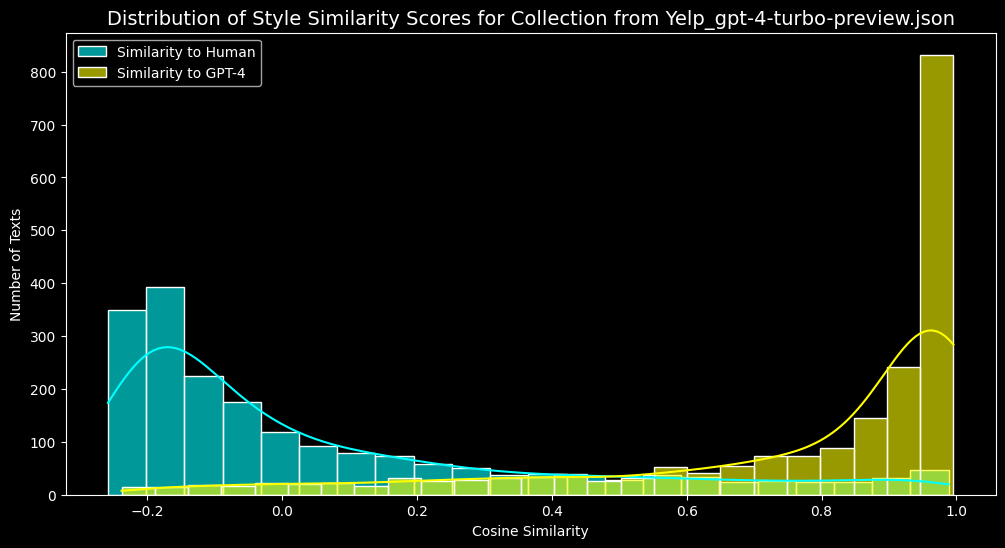

In [25]:
import pandas as pd
import numpy as np
import json
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
#  Prerequisites: Same as before
# ==============================================================================
# You must have the following available in your environment:
# - A trained `model` object (StyleContrastiveEncoder)
# - The corresponding `tokenizer`
# - The `get_embeddings` function
#
# ... (StyleContrastiveEncoder class and get_embeddings function definitions here) ...
#

class StyleAnalyzer:
    """
    An analyzer that uses a trained model and pre-calculated centroids
    to characterize the style of new texts.
    """
    def __init__(self, model, tokenizer, centroids_path):
        self.model = model.eval()
        self.tokenizer = tokenizer
        
        print("Loading Human and GPT-4 style centroids...")
        try:
            centroids = torch.load(centroids_path)
            self.human_centroid = centroids['human_centroid'].unsqueeze(0)
            self.gpt4_centroid = centroids['gpt4_centroid'].unsqueeze(0)
        except Exception as e:
            print(f"Error loading centroids from {centroids_path}: {e}")
            raise

        print("Style Analyzer is ready.")

    def get_style_scores(self, texts_to_analyze):
        """
        For a list of texts, calculates their similarity to the base Human and GPT-4 styles.
        Returns a DataFrame with the scores.
        """
        # Assuming get_embeddings is defined elsewhere
        embeddings = get_embeddings(texts_to_analyze, self.model, self.tokenizer)
        
        sim_to_human = cosine_similarity(embeddings, self.human_centroid.cpu().numpy())
        sim_to_gpt4 = cosine_similarity(embeddings, self.gpt4_centroid.cpu().numpy())
        
        df = pd.DataFrame({
            'text': texts_to_analyze,
            'human_similarity': sim_to_human.flatten(),
            'gpt4_similarity': sim_to_gpt4.flatten()
        })
        return df


def analyze_ai_collection(
    model,
    tokenizer,
    centroids_path,
    json_file_path
):
    """
    Performs a style analysis on a generic collection of AI texts from a JSON file.
    """
    print("\n" + "="*50)
    print(f"Starting Style Analysis on AI Collection from: '{json_file_path}'")
    print("="*50)

    # --- 1. Load All AI Texts from JSON File ---
    try:
        with open(json_file_path, 'r') as f:
            ai_collection_texts = json.load(f)
        if not isinstance(ai_collection_texts, list) or not all(isinstance(i, str) for i in ai_collection_texts):
             print("Error: JSON file must contain a flat list of strings. Exiting.")
             return
    except Exception as e:
        print(f"Error loading AI texts from {json_file_path}: {e}")
        return

    # --- 2. Initialize the Analyzer ---
    analyzer = StyleAnalyzer(model, tokenizer, centroids_path)

    # --- 3. Get Style Scores for the Collection ---
    print(f"\nAnalyzing {len(ai_collection_texts)} texts from the collection...")
    style_scores_df = analyzer.get_style_scores(ai_collection_texts)

    # --- 4. Calculate and Report the Style Profile ---
    print("\n--- Style Profile for the Collection ---")
    
    avg_human_sim = style_scores_df['human_similarity'].mean()
    avg_gpt4_sim = style_scores_df['gpt4_similarity'].mean()
    
    print(f"Average Similarity to 'Human' Style:      {avg_human_sim:.4f}")
    print(f"Average Similarity to 'GPT-4' Style:      {avg_gpt4_sim:.4f}")
    
    # Determine the overall leaning of the collection
    if avg_gpt4_sim > avg_human_sim:
        print("\nConclusion: On average, this collection's style is closer to the 'GPT-4' style print.")
    else:
        print("\nConclusion: On average, this collection's style is closer to the 'Human' style print.")
        
    # --- 5. (Optional) Visualize the Distribution of Scores ---
    plt.style.use('dark_background')
    plt.figure(figsize=(12, 6))
    sns.histplot(style_scores_df['human_similarity'], color='cyan', kde=True, label='Similarity to Human', alpha=0.6)
    sns.histplot(style_scores_df['gpt4_similarity'], color='yellow', kde=True, label='Similarity to GPT-4', alpha=0.6)
    plt.title(f'Distribution of Style Similarity Scores for Collection from {json_file_path}', fontsize=14)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Number of Texts')
    plt.legend()
    plt.show()


# ==============================================================================
#                                EXECUTION
# ==============================================================================
# Define the path to your JSON dataset and centroids file
JSON_DATASET_PATH = 'Yelp_gpt-4-turbo-preview.json'  # <-- Replace with your JSON file path
CENTROIDS_PATH = 'centroids.pt'  
model = detector.model
tokenizer = detector.tokenizer               # <-- Path to your pre-calculated centroids

# Run the style analysis on the JSON collection
analyze_ai_collection(
    model,
    tokenizer,
    CENTROIDS_PATH,
    JSON_DATASET_PATH
)

In [35]:
import pandas as pd
import numpy as np
import random
import json
import torch
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from datasets import load_dataset

# ==============================================================================
#  Prerequisites: Your classes and functions must be defined
# ==============================================================================
# You must have the following available in your environment:
# - A trained `model` object (StyleContrastiveEncoder)
# - The corresponding `tokenizer`
# - The `get_embeddings` function
# - The `FewShotDetector` class and a generic `ZeroShotDetector` class

class ZeroShotDetector:
    """A classifier that uses pre-loaded, fixed centroids for detection."""
    def __init__(self, model, tokenizer, centroids_path):
        self.model = model.eval()
        self.tokenizer = tokenizer
        try:
            centroids = torch.load(centroids_path)
            self.human_centroid = centroids['human_centroid'].unsqueeze(0)
            self.gpt4_centroid = centroids['gpt4_centroid'].unsqueeze(0)
        except Exception as e:
            raise IOError(f"Error loading centroids from {centroids_path}: {e}")
        print("Zero-shot detector (Human vs. GPT-4) is ready.")

    def predict(self, texts_to_classify):
        embeddings = get_embeddings(texts_to_classify, self.model, self.tokenizer)
        sim_to_human = cosine_similarity(embeddings, self.human_centroid.cpu().numpy())
        sim_to_gpt4 = cosine_similarity(embeddings, self.gpt4_centroid.cpu().numpy())
        return (sim_to_gpt4 > sim_to_human).astype(int).flatten()

class FewShotDetector:
    """A classifier that adapts to a new AI style using a small support set."""
    def __init__(self, model, tokenizer, human_centroid, ai_support_texts):
        self.model = model.eval()
        self.tokenizer = tokenizer
        self.human_centroid = human_centroid
        ai_embeddings = get_embeddings(ai_support_texts, self.model, self.tokenizer)
        self.ai_collection_centroid = np.mean(ai_embeddings, axis=0, keepdims=True)
        print("Specialized few-shot detector is ready.")

    def predict(self, texts_to_classify):
        embeddings = get_embeddings(texts_to_classify, self.model, self.tokenizer)
        sim_to_human = cosine_similarity(embeddings, self.human_centroid)
        sim_to_ai_collection = cosine_similarity(embeddings, self.ai_collection_centroid)
        return (sim_to_ai_collection > sim_to_human).astype(int).flatten()

def run_comparison_evaluation(
    model,
    tokenizer,
    centroids_path,
    json_file_path,
    num_support_samples=25
):
    """
    Performs both a zero-shot and a few-shot evaluation and compares the results.
    """
    print("\n" + "="*60)
    print(f"Starting Zero-Shot vs. Few-Shot Comparison for: '{json_file_path}'")
    print("="*60)

    # --- 1. Load Data ---
    try:
        with open(json_file_path, 'r') as f:
            ai_collection_texts = json.load(f)
    except Exception as e:
        print(f"Error loading AI texts: {e}"); return

    human_texts_for_query = load_dataset("liamdugan/raid", split='train').filter(
        lambda x: x['model'] == 'human'
    )['generation']
    random.shuffle(human_texts_for_query)
    
    # --- 2. Zero-Shot Evaluation ---
    print("\n--- STAGE 1: ZERO-SHOT EVALUATION ---")
    print("Using original Human vs. GPT-4 centroids for detection...")
    zero_shot_detector = ZeroShotDetector(model, tokenizer, centroids_path)
    zero_shot_predictions = zero_shot_detector.predict(ai_collection_texts)
    zero_shot_recall = np.mean(zero_shot_predictions)

    # --- 3. Few-Shot Evaluation ---
    print("\n--- STAGE 2: FEW-SHOT EVALUATION ---")
    print(f"Using {num_support_samples} samples to adapt the detector...")
    
    # Load human centroid for the few-shot detector
    centroids = torch.load(centroids_path, map_location='cpu')
    human_centroid = centroids['human_centroid'].numpy().reshape(1, -1)

    # Split AI data for few-shot learning
    random.shuffle(ai_collection_texts)
    ai_support_texts = ai_collection_texts[:num_support_samples]
    ai_query_texts = ai_collection_texts[num_support_samples:]

    # Create the adapted detector
    few_shot_detector = FewShotDetector(
        model,
        tokenizer,
        human_centroid=human_centroid,
        ai_support_texts=ai_support_texts
    )
    
    # Test on the unseen AI query set
    few_shot_predictions = few_shot_detector.predict(ai_query_texts)
    few_shot_recall = np.mean(few_shot_predictions)

    # --- 4. Final Comparison Report ---
    print("\n" + "="*60)
    print("                 PERFORMANCE COMPARISON")
    print("="*60)
    print(f"AI Text Collection: '{json_file_path}'")
    print("-" * 60)
    print("Metric: AI Detection Rate (Recall)\n")
    print(f"Zero-Shot Performance (No Adaptation):   {zero_shot_recall:.2%}")
    print(f"Few-Shot Performance ({num_support_samples}-shot Adaptation): {few_shot_recall:.2%}")
    print("-" * 60)
    
    improvement = few_shot_recall - zero_shot_recall
    print(f"Absolute Improvement from Adaptation: +{improvement:.2%}")
    if zero_shot_recall > 0:
        relative_improvement = improvement / zero_shot_recall
        print(f"Relative Improvement from Adaptation: +{relative_improvement:.2%}")
    print("="*60)


# ==============================================================================
#                                EXECUTION
# ==============================================================================
# Define the paths for your model, centroids, and the new JSON dataset
# MODEL_PATH = 'best_style_model.pt' # This should be loaded into the `model` object
CENTROIDS_PATH = 'centroids.pt'
JSON_DATASET_PATH = 'Arxiv_gemini-1.0-pro.json'

# Assuming `model`, `tokenizer`, and `get_embeddings` are already available
# Run the comparison
run_comparison_evaluation(
    model,
    tokenizer,
    CENTROIDS_PATH,
    JSON_DATASET_PATH,
    num_support_samples=100
)


Starting Zero-Shot vs. Few-Shot Comparison for: 'Arxiv_gemini-1.0-pro.json'



--- STAGE 1: ZERO-SHOT EVALUATION ---
Using original Human vs. GPT-4 centroids for detection...
Zero-shot detector (Human vs. GPT-4) is ready.


Generating Embeddings: 100%|██████████| 11/11 [00:03<00:00,  3.37it/s]



--- STAGE 2: FEW-SHOT EVALUATION ---
Using 100 samples to adapt the detector...


Generating Embeddings: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]


Specialized few-shot detector is ready.


Generating Embeddings: 100%|██████████| 8/8 [00:02<00:00,  3.46it/s]


                 PERFORMANCE COMPARISON
AI Text Collection: 'Arxiv_gemini-1.0-pro.json'
------------------------------------------------------------
Metric: AI Detection Rate (Recall)

Zero-Shot Performance (No Adaptation):   59.71%
Few-Shot Performance (100-shot Adaptation): 70.00%
------------------------------------------------------------
Absolute Improvement from Adaptation: +10.29%
Relative Improvement from Adaptation: +17.22%
